Program przy pierwszym uruchomieni stworzy na pulpicie folder nazwany Notes w którym będą zapisywane rezultaty.
Do poprawnego działania tego notatnika potrzebne jest zainstalowanie programu musescore, który konwertuje xml midi na grafikę z nutami. Można go pobrać tutaj:https://musescore.org/en


Instalacja potrzebnych bibliotek.

In [1]:
! pip3 install matplotlib
! pip3 install scipy

In [2]:
import copy
import platform
import random
import os
from music21 import *
from music21 import interval
from music21 import scale
from music21.note import Note, Rest
from music21 import interval
from music21 import scale
from music21.note import Note

Klasa reprezentująca pojedyńczą nutę w populacji.

In [3]:
class MusicNote(object):
    location = 0
    fitness_score = 0.0
    melody_direction_fitness = 0
    is_first_note_of_melody = False
    is_last_note_of_melody = False
    note_interval = None

    def __init__(self, music_note: Note, fitness_score: 0.0, note_interval, location, is_last = False):
        self.note_interval = note_interval
        self.music_note: Note = music_note
        self.fitness_score = fitness_score
        self.location = location
        if location == 0:
            self.is_first_note_of_melody = True
        self.is_last_note_of_melody = is_last

    def __repr__(self):
        return repr(self.fitness_score)

Klasa reprezentująca cała populacje nut.

In [4]:
class MusicPeace(object):
    all_notes = []
    temp_notes = []
    bars_number = 0
    note_ids = []

    def __init__(self, bars_number):
        self.bars_number = bars_number
        self.get_all_notes(0.0)

    def get_all_notes(self, note_fitness_score):
        self.get_temp_notes()
        self.create_notes(note_fitness_score)

    def get_temp_notes(self):
        count = 0
        bars_count = 0
        while bars_count < self.bars_number * 4:
            tone = self.generate_scale_tone(self.temp_notes, count)
            self.temp_notes.append(tone)
            bars_count = self.calculate_if_bars_are_done()
            count = count + 1

    def calculate_if_bars_are_done(self):
        count = 0
        for note in self.temp_notes:
            count = count + note.duration.quarterLength
        return count

    @staticmethod
    def generate_scale_tone(notes: [], count):
        items = ['C', 'D', 'E', 'F', 'G', 'A', 'B', 'C#', 'D#', 'F#', 'G#', 'A#']

        rand_item = items[random.randrange(len(items))]

        scales = scale.MajorScale(rand_item)

        all_pitches = list(set([pitch for pitch in scales.getPitches()]))
        all_note_names = [i.name for i in all_pitches]

        note_name = random.choice(all_note_names)

        final_note = Note(note_name)

        duration_list = [1, 1 / 2]

        if not notes:
            final_note.duration.quarterLength = random.choice(duration_list)
            return final_note

        try:
            if notes[count - 1].duration.quarterLength == 1 / 2 and notes[count - 2].duration.quarterLength != 1 / 2:
                final_note.duration.quarterLength = 1 / 2
                return final_note
        except:
            if count == 0:
                final_note.duration.quarterLength = 1 / 2
                return final_note
            else:
                pass
        else:
            final_note.duration.quarterLength = random.choice(duration_list)
            return final_note

    def create_notes(self, note_fitness_score):
        for index in range(0, len(self.temp_notes)):
            note = self.temp_notes[index]

            if index + 1 >= len(self.temp_notes):
                note_interval = interval.Interval(note, second_note)
                self.all_notes.append(MusicNote(note, note_fitness_score, note_interval, index, is_last=True))
                continue

            second_note = self.temp_notes[index + 1]
            note_interval = interval.Interval(note, second_note)

            if index == 0:
                self.all_notes.append(MusicNote(note, note_fitness_score, note_interval, index))
                continue

            self.all_notes.append(MusicNote(note, note_fitness_score, note_interval, index))
            

Główna definicja funkcji algorytmu genetycznego.

In [5]:
def genetic_algorithm(attempts, initial_population):
    population = initial_population

    evaluate_fitness(population)

    count = 0
    while count != attempts:
        counter = 0
        population_temp = copy.copy(population)

        while counter != 1:

            eliminated_note = tournament_selection(population_temp, len(population_temp))

            new_note = mutate(eliminated_note)

            altered_note = MusicNote(new_note, 0, None, eliminated_note.location,
                                               eliminated_note.is_last_note_of_melody)

            population[eliminated_note.location] = altered_note

            counter = counter + 1

        recalculate_intervals(population)
        evaluate_fitness(population)

        average_fitness = calculate_average_fitness(population)
        print("Generation: {0}".format(count), end="\r", flush=True)

        count += 1
    add_rests(0.05, population)
    print("Generations run: {0}, with total average fitness of {1}".format(count,average_fitness))
    return population




Funkcja przystosowania.

In [6]:
def evaluate_fitness(population: [MusicNote]):
    melody_direction_fitness(population)
    scales = scale.MajorScale('G')

    for index in range(0, len(population), 1):
        indexed_note = population[index]

        if population[index].is_last_note_of_melody:
            last_note_fitness = first_or_last_note_fitness(indexed_note, scales)
            indexed_note.fitness_score = last_note_fitness
            continue

        if population[index].is_first_note_of_melody:
            first_note_fitness = first_or_last_note_fitness(indexed_note, scales)
            indexed_note.fitness_score = first_note_fitness
            continue

        second_note = population[index + 1]

        step_relationship = notes_relationship(indexed_note, second_note)
        degree_fitness_value = degree_fitness(indexed_note, second_note)
        drastic_duration_change_fitness = drastic_duration_change_fitness_function(indexed_note, second_note)

        indexed_note.fitness_score = (step_relationship + indexed_note.melody_direction_fitness +
                                      degree_fitness_value + drastic_duration_change_fitness) / 4


def add_rests(proportion, population):
    while not is_proportion_in_range(proportion, population):
        random_index = random.randint(1, len(population) - 2)
        population[random_index].music_note = Rest()


def is_proportion_in_range(proportion, population):
    current_rest_proportion = calculate_rest_proportion(population)
    if proportion - 0.05 <= current_rest_proportion <= proportion + 0.05:
        return True
    else:
        return False


def calculate_rest_proportion(population):
    counter = 0

    for n in population:
        if n.music_note.isRest:
            counter = counter + 1
    if counter == 0:
        return 0
    else:
        return counter / len(population)


def drastic_duration_change_fitness_function(note1, note2):
    proportion = note1.music_note.duration.quarterLength / note2.music_note.duration.quarterLength

    if proportion > 4:
        return 0.2
    else:
        return 1


def degree_fitness(note1: MusicNote, note2: MusicNote):
    chosen_scale = scale.MajorScale('G')
    degree1 = chosen_scale.getScaleDegreeFromPitch(note1.music_note.pitch)
    degree2 = chosen_scale.getScaleDegreeFromPitch(note2.music_note.pitch)

    if degree1 is None:
        return 0.2
    if degree2 is None:
        return 0.2

    if degree1 > degree2:
        difference = degree1 - degree2
    else:
        difference = degree2 - degree1

    if difference > 4:
        return 0.2
    else:
        return 1


def get_root_pitch(song_scale):
    pitches = get_scale_pitches(song_scale)
    all_note_names = [i.name for i in pitches]
    return all_note_names[0]

def get_scale_pitches(scale_local):
    scale_pitches = []
    for p in scale_local.pitches:
        scale_pitches.append(p)
    return scale_pitches

def first_or_last_note_fitness(first_note: MusicNote, song_scale):
    if first_note.music_note.pitch.name == get_root_pitch(song_scale):
        return 1
    else:
        return 0


def assign_melody_direction_fitness(note1: MusicNote, note2: MusicNote, note3: MusicNote):
    if note3 is None:
        return
    if note2 is None:
        return
    return fitness_melody_direction2(note1, note2)


def fitness_melody_direction2(note1: MusicNote,
                              note2: MusicNote
                              ):
    if note1.note_interval.direction == 1 and note2.note_interval.direction == 1:
        return 1

    if note1.note_interval.direction == -1 and \
            note2.note_interval.direction == -1:
        return 1

    if note1.note_interval.direction == 0 and \
            note2.note_interval.direction == 0:
        return 0.7
    else:
        return 0.4


def fitness_melody_direction(note1: MusicNote,
                             note2: MusicNote,
                             note3: MusicNote):
    if note1.note_interval.direction == 1 and \
            note2.note_interval.direction == 1 and \
            note3.note_interval.direction == 1:
        return 1

    if note1.note_interval.direction == -1 and \
            note2.note_interval.direction == -1 and \
            note3.note_interval.direction == -1:
        return 1

    if note1.note_interval.direction == 0 and \
            note2.note_interval.direction == 0 and \
            note3.note_interval.direction == 0:
        return 1
    else:
        return 0.2


def notes_relationship(note_one, note_two):
    one_step_relationship = one_step(note_one.music_note, note_two.music_note)
    two_step_relationship = two_steps(note_one.music_note, note_two.music_note)
    three_steps_relationship = three_steps(note_one.music_note, note_two.music_note)
    same_note_relationship = same_distance(note_one.music_note, note_two.music_note)
    return (one_step_relationship + two_step_relationship + three_steps_relationship + same_note_relationship) / 4


def one_step(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'M2' or 'm2':
        return 0.2
    else:
        return 0


def two_steps(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'M3' or 'm3':
        return 1
    else:
        return 0


def three_steps(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'P4' or 'A4':
        return 0.7
    else:
        return 0


def same_distance(note_one, note_two):
    if interval.notesToGeneric(note_one, note_two) == 'P1':
        return 0.2
    else:
        return 0

def calculate_average_fitness(population: [MusicNote]):
    total = 0
    for n in population:
        total += n.fitness_score
    return total / len(population)


def melody_direction_fitness(population):
    for index in range(0, len(population) - 2, 1):
        first_note = population[index]
        second_note = population[index + 1]
        third_note = population[index + 2]

        direction_fitness = assign_melody_direction_fitness(first_note, second_note, third_note)

        first_note.melody_direction_fitness = direction_fitness


def recalculate_intervals(temp_notes):
    for index in range(0, len(temp_notes)):
        first_note = temp_notes[index]

        if index + 1 >= len(temp_notes):
            this_interval = interval.Interval(first_note.music_note, temp_notes[index - 1].music_note)
            temp_notes[index].note_interval = this_interval
            continue

        second_note = temp_notes[index + 1]
        this_interval = interval.Interval(first_note.music_note, second_note.music_note)

        if index == 0:
            temp_notes[index].note_interval = this_interval
            continue

        temp_notes[index].note_interval = this_interval

Funkcje używane przy mutacji.

In [7]:
def mutate(parent):
    random_note = generate_scale_tone_mutation(parent)
    parent.music_note = random_note
    return parent.music_note

def generate_scale_tone_mutation(parent):
    scales = scale.MajorScale('G')

    all_pitches = list(set([pitch for pitch in scales.getPitches()]))
    all_note_names = [i.name for i in all_pitches]

    note_name = random.choice(all_note_names)

    final_note = Note(note_name)

    final_note.duration.quarterLength = parent.music_note.duration.quarterLength
    return final_note


Funkcja w której zachodzi selekcja na podstawie turnieju.

In [8]:
def tournament_selection(population: [MusicNote], population_size):
    worst = None
    i = 1

    population_temp = copy.copy(population)

    while i < population_size:

        list_length = len(population_temp)
        if list_length == 0:
            if worst in population:
                population.remove(worst)
            return worst

        individual = population_temp.pop(random.randint(0, list_length - 1))
        if worst is None or individual.fitness_score < worst.fitness_score:
            worst = individual
        i += 1

    if worst in population:
        population.remove(worst)

    return worst


Ustawienie systemowe.

In [9]:
def setup_environment():
    if platform.system() == "Windows":
        path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop\\Notes\\')
    else:
        path = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop/Notes')
    if not os.path.exists(path) or not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError:
            print("Creation of the directory %s failed" % path)
        else:
            print("Successfully created the directory %s " % path)

    environment.set('directoryScratch', path)


Główna funkcja programu, aby uruchomić ponownie proszę wyczyścić notatnik.

Generations run: 1000, with total average fitness of 0.7602272727272728


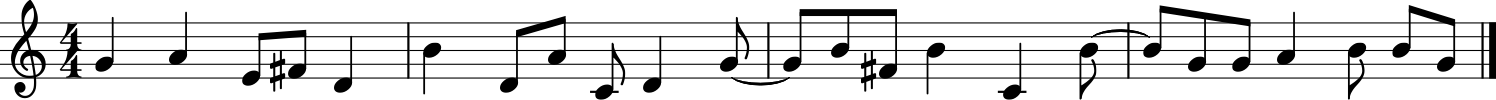

In [10]:
def main():
    setup_environment()

    initial_population = MusicPeace(4)  # amount of bars in melody G dur scale 4/8/16 etc

    final_population = genetic_algorithm(1000, initial_population.all_notes) # number of generations to run

    try:
        s1 = stream.Stream()
        for n in final_population:
            s1.append(n.music_note)
        s1.show()
    except:
          print("To display notes muse score software is required please install it from here: https://musescore.org/en")
    
if __name__ == '__main__':
    main()